In [29]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

from Levenshtein import distance as Ldistance

import training_utils.dataset_utils as data_utils
import training_utils.partitioning_utils as pat_utils

import importlib
import training_utils.train_utils as train_utils
importlib.reload(train_utils)

Tesla V100-SXM2-32GB


<module 'training_utils.train_utils' from '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/training_utils/train_utils.py'>

In [2]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

batch_size = 20
learning_rate = 2e-5
EPOCHS = 15

In [6]:
## Model Class
### MiniClip 
# def gaussian_kernel(x, sigma):
#     return np.exp(-x**2 / (2 * sigma**2))

# def transform_vector(vector, sigma):

#     interacting_indices = np.where(vector == 1)[0]   # positions where vector == 1
#     transformed_vector = np.zeros_like(vector, dtype=float)
    
#     for i in range(len(vector)):
#         if vector[i] == 0:
#             distances = np.abs(interacting_indices - i)   # distance to all "1"s
#             min_distance = np.min(distances)              # closest "1"
#             transformed_vector[i] = gaussian_kernel(min_distance, sigma)
#         else:
#             transformed_vector[i] = 1.0
#     return transformed_vector

# def safe_shuffle(n, device):
#     shuffled = torch.randperm(n, device=device)
#     while torch.any(shuffled == torch.arange(n, device=device)):
#         shuffled = torch.randperm(n, device=device)
#     return shuffled

def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [7]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

## Embeddings paths
binders_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
targets_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB

print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [8]:
### Loading the dataset
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["observation_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["observation_weight"]))
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,observation_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159
...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159


In [9]:
binders_per_target = dict(interaction_df['target_id_mod'].value_counts())
targets = interaction_df['target_id_mod'].unique().tolist()

# 5-fold CV training + weighting of samples

In [10]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [11]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


### Creating separate targets/ binder dataframes

In [26]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")
binder_df["observation_weight"] = binder_df.index.map(weights_Dict)

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

### Creating class for loading binders/targets

In [13]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████████████████████████| 3532/3532 [00:04<00:00, 782.79it/s]


In [14]:
# Cheking whether index=0 is embedding of the first element of the dataframe 
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Loading pretrained model for finetuning

In [15]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [30]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

### Loading training and validation datasets (inversitgation script for loading training set/ validation set from one of the folds)

In [35]:
# val_targets = cv_splits[0][0]
# train_targets = cv_splits[0][1]

# class PairListDataset(Dataset):
#     def __init__(self, examples, weights=None):
#         self.examples = examples
        
#     def __len__(self):
#         return len(self.examples)

#     def __getitem__(self, idx):
#         b, t, y = self.examples[idx]
#         b = torch.as_tensor(b, dtype=torch.float32)
#         t = torch.as_tensor(t, dtype=torch.float32)
#         y = torch.tensor(float(y), dtype=torch.float32)
#         return b, t, y

# val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
# val_binders = [ALL_btl[idx] for idx in val_idx]
# val_binders = PairListDataset(val_binders)

# ### weighting
# # train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
# # train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
# # train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
# # train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_account_pos"].tolist()

# train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
# train_binders = [ALL_btl[idx] for idx in train_idx]
# train_binders = PairListDataset(train_binders)

# train_loader = DataLoader(train_binders, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_binders, batch_size=32, shuffle=False)

# batch = next(iter(val_loader))
# print(f"Shape of the binders embeddings : {batch[0].shape}")
# print(f"Shape of the targets embeddings : {batch[1].shape}")
# print(f"Labels (0 - non-binder, 1 - binder) :{(batch[2].numpy())}\n")

# with torch.no_grad():
#     for batch in val_loader:
#         loss, logits, labels = model.validation_step(batch, device)

# with torch.no_grad():
#     batch = next(iter(val_loader))
#     loss, logits, labels = model.validation_step(batch, device)
#     print(logits)
#     print(labels)
#     print(loss)

In [36]:
# logits = torch.tensor([ 3.3079,  2.7373,  3.2731,  2.8155,  1.3012,  0.7854,  0.4648, -0.0547,
#         -1.3015, -1.6521, -2.1687, -2.6845, -2.6755,  2.7531,  1.4217,  1.9008,
#          3.0363,  2.5157,  3.3423, -3.1149, -3.7827, -3.1243, -0.7014, -2.1950,
#         -1.8157,  2.0637,  1.4938,  2.1506,  1.5810,  1.8863,  1.7177,  1.7518],
#                       dtype=torch.float32)
# labels = torch.tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
#         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=torch.float32)

# F.binary_cross_entropy_with_logits(logits, labels)

In [39]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_loader   = DataLoader(train_binders_ds,  batch_size=20, generator=g)

for bi, batch in enumerate(train_loader):
    _, _, labels, ids = batch
    c = Counter(ids)
    print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    if bi == 20: break  # first 5 batches

Batch 0: {'VirB8': 1, 'FGFR2': 17, 'InsulinR': 2}  | positives=0 / 20
Batch 1: {'InsulinR': 5, 'FGFR2': 11, 'EGFR': 4}  | positives=1 / 20
Batch 2: {'EGFR': 2, 'FGFR2': 18}  | positives=2 / 20
Batch 3: {'FGFR2': 8, 'Pdl1': 6, 'EGFR_2': 1, 'TrkA': 5}  | positives=2 / 20
Batch 4: {'TrkA': 3, 'EGFR_2': 9, 'EGFR': 2, 'VirB8': 3, 'FGFR2': 1, 'IL10Ra': 2}  | positives=2 / 20
Batch 5: {'EGFR_2': 1, 'LTK': 2, 'FGFR2': 17}  | positives=1 / 20
Batch 6: {'FGFR2': 20}  | positives=2 / 20
Batch 7: {'FGFR2': 10, 'EGFR_2': 2, 'VirB8': 2, 'Mdm2': 6}  | positives=4 / 20
Batch 8: {'FGFR2': 16, 'EGFR_2': 4}  | positives=1 / 20
Batch 9: {'VirB8': 1, 'FGFR2': 14, 'InsulinR': 5}  | positives=2 / 20
Batch 10: {'FGFR2': 15, 'EGFR': 4, 'InsulinR': 1}  | positives=6 / 20
Batch 11: {'FGFR2': 20}  | positives=2 / 20
Batch 12: {'FGFR2': 5, 'Pdl1': 6, 'TrkA': 6, 'EGFR_2': 3}  | positives=4 / 20
Batch 13: {'TrkA': 2, 'EGFR_2': 5, 'EGFR': 4, 'VirB8': 4, 'FGFR2': 2, 'IL10Ra': 2, 'LTK': 1}  | positives=2 / 20
Batch 14:

#### not balanced bathes : (1) many instances of target "FGFR2" (2) in some of the batches no positives present

In [21]:
import gc, torch
# del obj  # any large temps you created in the cell
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# print_mem_consumption()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.cuda.empty_cache()
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.065011712
Allocated memory:  0.0
Free memory:  0.008080896


### Training loop

In [24]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return

        if scores.size == 0: continue
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                av_pos = float(np.mean(scores[pos_mask])) if pos_mask.any() else float("nan")
                av_neg = float(np.mean(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = av_pos - av_neg if np.isfinite(av_pos) and np.isfinite(av_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_mean_logit": av_pos,
                    "val_neg_mean_logit": av_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Train Loss,█▂▁▁▁▁▁
Val AUPR,▁█▆█▇█▆▆
Val AUROC,▁█▇▇▇█▇▇
Val Loss,█▁▁▁▁▁▁▁
epoch_#,▁▂▃▅▆▇█
Train Loss,0.30532
Val AUPR,0.21936
Val AUROC,0.63598
Val Loss,0.37164
epoch_#,7


Training model 58d9a9f8-1e0c-4542-86cb-57f59412359c


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:18<00:00,  6.25it/s]


Before training - Val Loss 9.3151 | Val AUROC 0.4492 | Val AUPR 0.1075


Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.50it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [00:43<06:33, 43.67s/it]

EPOCH 1 - Train Loss 0.7333 | Val Loss 0.3789 | Val AUROC 0.5997 | Val AUPR 0.2130



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.49it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [01:27<05:50, 43.82s/it]

EPOCH 2 - Train Loss 0.3709 | Val Loss 0.4186 | Val AUROC 0.6347 | Val AUPR 0.2353



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.51it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [02:11<05:06, 43.81s/it]

EPOCH 3 - Train Loss 0.3270 | Val Loss 0.3430 | Val AUROC 0.6144 | Val AUPR 0.2364



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.50it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [02:55<04:22, 43.81s/it]

EPOCH 4 - Train Loss 0.3214 | Val Loss 0.3397 | Val AUROC 0.6434 | Val AUPR 0.2535



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.51it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [03:38<03:39, 43.80s/it]

EPOCH 5 - Train Loss 0.3245 | Val Loss 0.3574 | Val AUROC 0.6651 | Val AUPR 0.2623



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.49it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [04:22<02:55, 43.85s/it]

EPOCH 6 - Train Loss 0.3071 | Val Loss 0.3399 | Val AUROC 0.6323 | Val AUPR 0.2261



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.50it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [05:06<02:11, 43.82s/it]

EPOCH 7 - Train Loss 0.3077 | Val Loss 0.3638 | Val AUROC 0.6563 | Val AUPR 0.2415



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.53it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [05:49<01:27, 43.63s/it]

EPOCH 8 - Train Loss 0.3002 | Val Loss 0.3746 | Val AUROC 0.6436 | Val AUPR 0.2451



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.53it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [06:33<00:43, 43.55s/it]

EPOCH 9 - Train Loss 0.2893 | Val Loss 0.3320 | Val AUROC 0.6532 | Val AUPR 0.2295



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.52it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.67s/it]


EPOCH 10 - Train Loss 0.3039 | Val Loss 0.3249 | Val AUROC 0.6894 | Val AUPR 0.2803


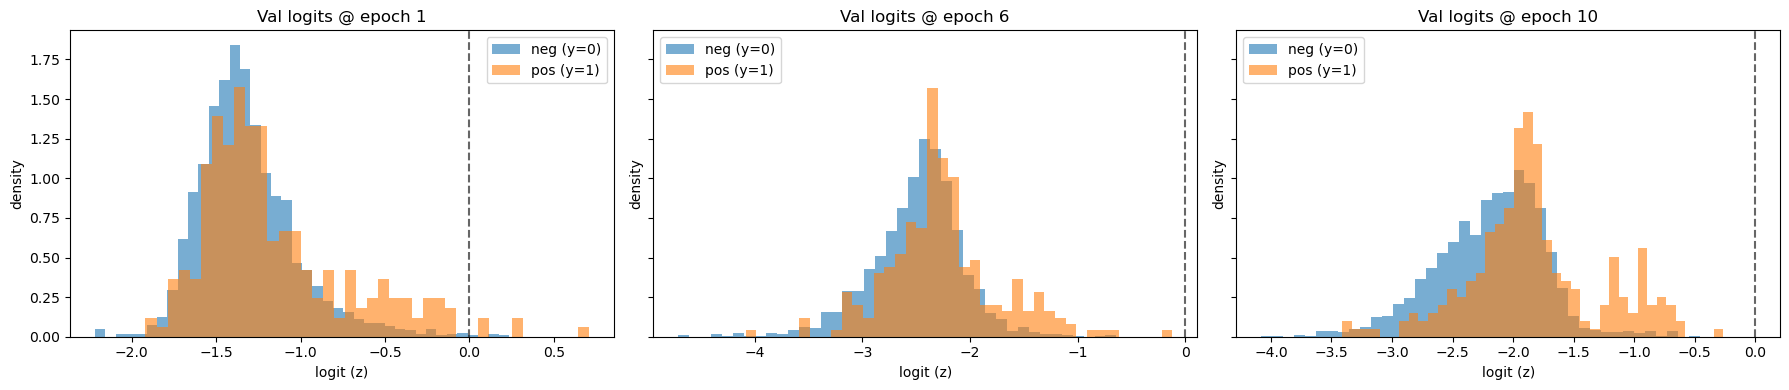

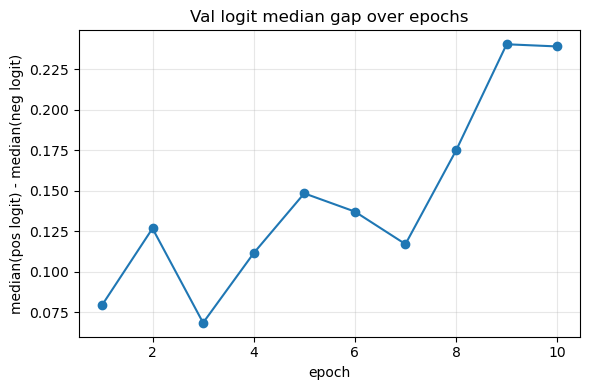

Train Loss,█▂▂▂▂▁▁▁▁▁
Val AUPR,▁▅▆▆▇▇▆▆▇▆█
Val AUROC,▁▅▆▆▇▇▆▇▇▇█
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▁▃▁▃▄▄▃▅██
val_neg_median_logit,█▁▄▅▃▅▃▂▆▆
val_pos_median_logit,█▁▄▅▃▅▃▂▆▆
Train Loss,0.30386
Val AUPR,0.28029
Val AUROC,0.68938
Val Loss,0.32486


Training model 58d9a9f8-1e0c-4542-86cb-57f59412359c


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.34it/s]


Before training - Val Loss 9.1706 | Val AUROC 0.4674 | Val AUPR 0.1505


Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [01:06<09:56, 66.31s/it]

EPOCH 1 - Train Loss 0.4776 | Val Loss 1.5943 | Val AUROC 0.5055 | Val AUPR 0.1609



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [02:12<08:49, 66.24s/it]

EPOCH 2 - Train Loss 0.3136 | Val Loss 1.7696 | Val AUROC 0.4501 | Val AUPR 0.1479



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [03:18<07:43, 66.23s/it]

EPOCH 3 - Train Loss 0.3072 | Val Loss 1.4661 | Val AUROC 0.4090 | Val AUPR 0.1394



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [04:24<06:37, 66.24s/it]

EPOCH 4 - Train Loss 0.3069 | Val Loss 1.5431 | Val AUROC 0.4143 | Val AUPR 0.1385



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [05:31<05:31, 66.25s/it]

EPOCH 5 - Train Loss 0.2972 | Val Loss 0.8588 | Val AUROC 0.4094 | Val AUPR 0.1376



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [06:37<04:24, 66.24s/it]

EPOCH 6 - Train Loss 0.3000 | Val Loss 1.3168 | Val AUROC 0.3829 | Val AUPR 0.1334



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [07:43<03:18, 66.23s/it]

EPOCH 7 - Train Loss 0.2891 | Val Loss 2.0850 | Val AUROC 0.3843 | Val AUPR 0.1313



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [08:49<02:12, 66.22s/it]

EPOCH 8 - Train Loss 0.2814 | Val Loss 2.7360 | Val AUROC 0.3697 | Val AUPR 0.1286



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [09:56<01:06, 66.24s/it]

EPOCH 9 - Train Loss 0.2750 | Val Loss 1.4618 | Val AUROC 0.3823 | Val AUPR 0.1315



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:02<00:00, 66.25s/it]


EPOCH 10 - Train Loss 0.2592 | Val Loss 1.1292 | Val AUROC 0.3863 | Val AUPR 0.1323


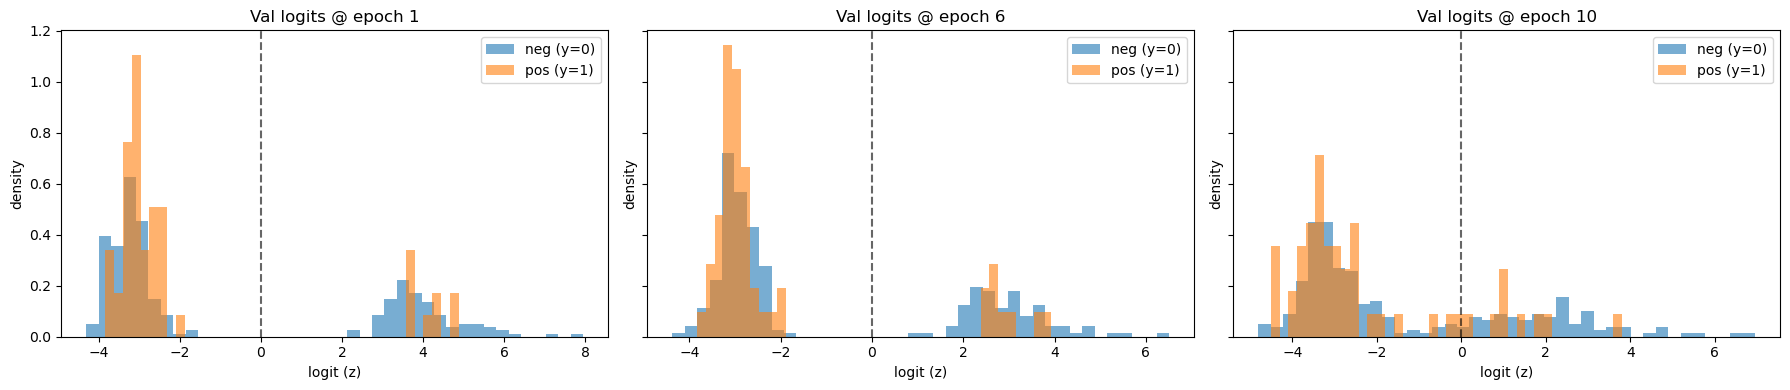

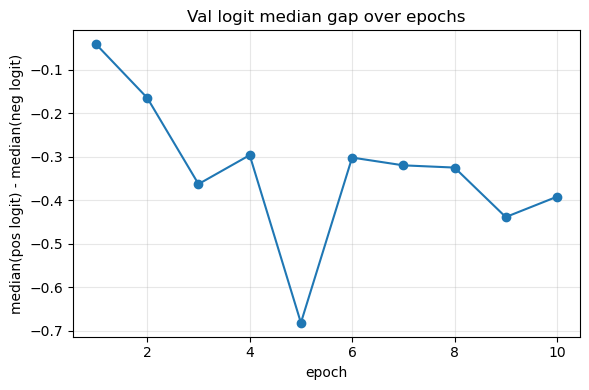

Train Loss,█▃▃▃▂▂▂▂▂▁
Val AUPR,▆█▅▃▃▃▂▂▁▂▂
Val AUROC,▆█▅▃▃▃▂▂▁▂▂
Val Loss,█▂▂▂▂▁▁▂▃▂▁
val_logit_gap,█▇▄▅▁▅▅▅▄▄
val_neg_median_logit,▃▁██▄▄▃▂▄▄
val_pos_median_logit,▃▁██▂▃▃▂▃▃
Train Loss,0.2592
Val AUPR,0.13226
Val AUROC,0.3863
Val Loss,1.12921


Training model 58d9a9f8-1e0c-4542-86cb-57f59412359c


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.44it/s]


Before training - Val Loss 8.7743 | Val AUROC 0.3822 | Val AUPR 0.0976


Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.53it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [01:07<10:03, 67.01s/it]

EPOCH 1 - Train Loss 0.4880 | Val Loss 0.3499 | Val AUROC 0.5607 | Val AUPR 0.1394



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.54it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [02:13<08:54, 66.85s/it]

EPOCH 2 - Train Loss 0.3171 | Val Loss 0.3646 | Val AUROC 0.5842 | Val AUPR 0.1751



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.54it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [03:20<07:47, 66.81s/it]

EPOCH 3 - Train Loss 0.3202 | Val Loss 0.3576 | Val AUROC 0.5247 | Val AUPR 0.1194



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.54it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [04:27<06:40, 66.82s/it]

EPOCH 4 - Train Loss 0.3139 | Val Loss 0.3546 | Val AUROC 0.5714 | Val AUPR 0.1607



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.53it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [05:34<05:34, 66.91s/it]

EPOCH 5 - Train Loss 0.3086 | Val Loss 0.3778 | Val AUROC 0.5601 | Val AUPR 0.1424



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.53it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [06:41<04:27, 66.92s/it]

EPOCH 6 - Train Loss 0.2974 | Val Loss 0.3511 | Val AUROC 0.5895 | Val AUPR 0.1655



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.55it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [07:47<03:20, 66.79s/it]

EPOCH 7 - Train Loss 0.2911 | Val Loss 0.3702 | Val AUROC 0.5827 | Val AUPR 0.1573



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.54it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [08:54<02:13, 66.77s/it]

EPOCH 8 - Train Loss 0.2832 | Val Loss 0.4101 | Val AUROC 0.4370 | Val AUPR 0.1000



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.54it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [10:01<01:06, 66.79s/it]

EPOCH 9 - Train Loss 0.2786 | Val Loss 0.4199 | Val AUROC 0.5350 | Val AUPR 0.1231



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.53it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:08<00:00, 66.84s/it]


EPOCH 10 - Train Loss 0.2647 | Val Loss 0.4754 | Val AUROC 0.5135 | Val AUPR 0.1154


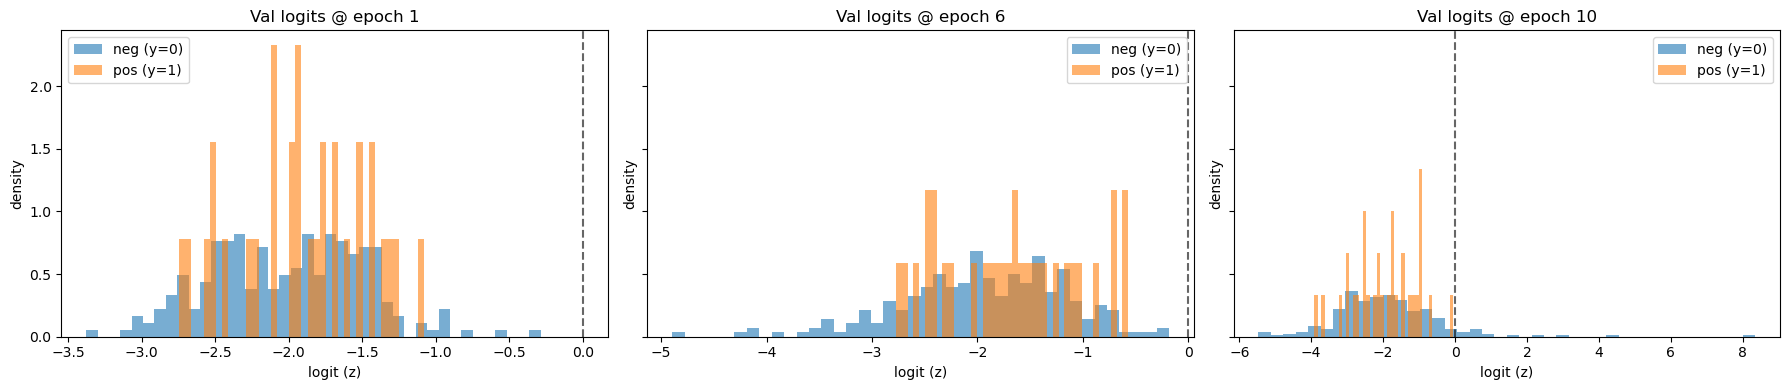

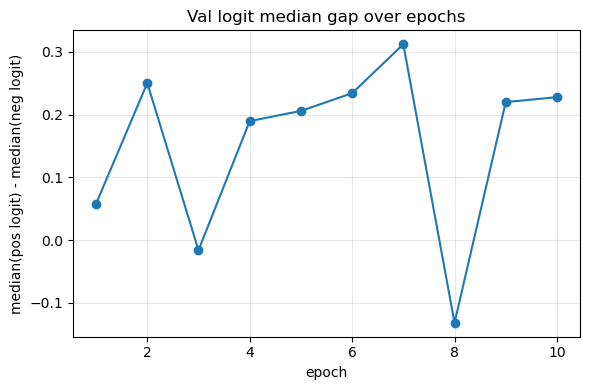

Train Loss,█▃▃▃▂▂▂▂▁▁
Val AUPR,▁▅█▃▇▅▇▆▁▃▃
Val AUROC,▁▇█▆▇▇██▃▆▅
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▄▇▃▆▆▇█▁▇▇
val_neg_median_logit,▆▁▆▆█▆▅▆▆▅
val_pos_median_logit,▅▁▅▆█▆▅▅▆▅
Train Loss,0.2647
Val AUPR,0.11535
Val AUROC,0.51353
Val Loss,0.47537


Training model 58d9a9f8-1e0c-4542-86cb-57f59412359c


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.35it/s]


Before training - Val Loss 10.7452 | Val AUROC 0.6137 | Val AUPR 0.0860


Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [01:03<09:31, 63.49s/it]

EPOCH 1 - Train Loss 0.5138 | Val Loss 0.3775 | Val AUROC 0.5502 | Val AUPR 0.1279



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.53it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [02:07<08:28, 63.54s/it]

EPOCH 2 - Train Loss 0.3384 | Val Loss 0.3889 | Val AUROC 0.5201 | Val AUPR 0.1071



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [03:10<07:24, 63.45s/it]

EPOCH 3 - Train Loss 0.3352 | Val Loss 0.4826 | Val AUROC 0.5379 | Val AUPR 0.0905



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [04:13<06:20, 63.40s/it]

EPOCH 4 - Train Loss 0.3237 | Val Loss 0.4115 | Val AUROC 0.5238 | Val AUPR 0.0973



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.52it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [05:17<05:17, 63.58s/it]

EPOCH 5 - Train Loss 0.3178 | Val Loss 0.3991 | Val AUROC 0.5429 | Val AUPR 0.0824



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.53it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [06:21<04:14, 63.58s/it]

EPOCH 6 - Train Loss 0.3107 | Val Loss 0.2865 | Val AUROC 0.4942 | Val AUPR 0.0720



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [07:24<03:10, 63.51s/it]

EPOCH 7 - Train Loss 0.3050 | Val Loss 0.3110 | Val AUROC 0.5609 | Val AUPR 0.0813



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [08:28<02:06, 63.49s/it]

EPOCH 8 - Train Loss 0.2951 | Val Loss 0.2792 | Val AUROC 0.5072 | Val AUPR 0.0708



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [09:31<01:03, 63.47s/it]

EPOCH 9 - Train Loss 0.2995 | Val Loss 0.3707 | Val AUROC 0.4537 | Val AUPR 0.0645



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.54it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:34<00:00, 63.49s/it]


EPOCH 10 - Train Loss 0.2747 | Val Loss 0.2903 | Val AUROC 0.5275 | Val AUPR 0.0740


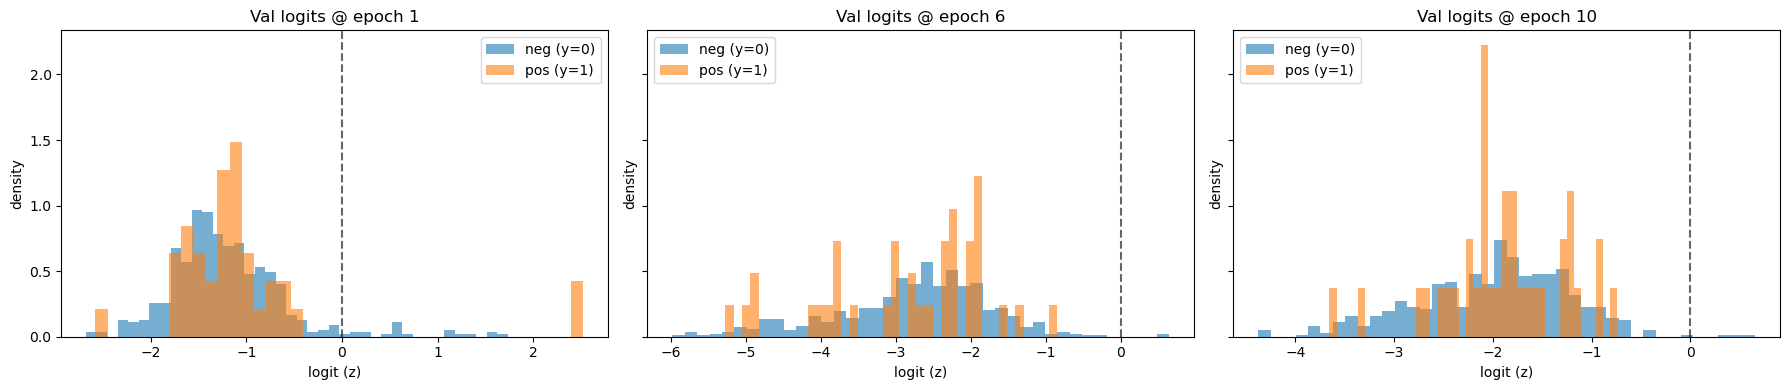

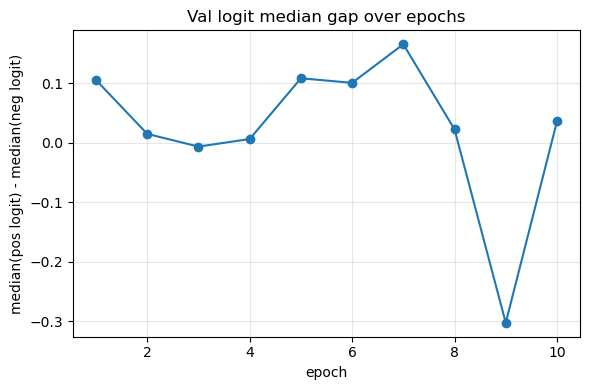

Train Loss,█▃▃▂▂▂▂▂▂▁
Val AUPR,▃█▆▄▅▃▂▃▂▁▂
Val AUROC,█▅▄▅▄▅▃▆▃▁▄
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▇▆▅▆▇▇█▆▁▆
val_neg_median_logit,▇▇█▇▇▁▄▂▄▄
val_pos_median_logit,▇▇█▇▇▁▄▁▂▄
Train Loss,0.27469
Val AUPR,0.07397
Val AUROC,0.52746
Val Loss,0.29031


Training model 58d9a9f8-1e0c-4542-86cb-57f59412359c


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.05it/s]


Before training - Val Loss 10.2395 | Val AUROC 0.4852 | Val AUPR 0.1659


Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.53it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [01:08<10:12, 68.05s/it]

EPOCH 1 - Train Loss 0.4991 | Val Loss 0.3649 | Val AUROC 0.5493 | Val AUPR 0.1497



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.53it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [02:16<09:04, 68.06s/it]

EPOCH 2 - Train Loss 0.3235 | Val Loss 0.3845 | Val AUROC 0.5695 | Val AUPR 0.1335



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.53it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [03:24<07:56, 68.07s/it]

EPOCH 3 - Train Loss 0.3246 | Val Loss 0.3393 | Val AUROC 0.5385 | Val AUPR 0.1412



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.52it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [04:32<06:48, 68.15s/it]

EPOCH 4 - Train Loss 0.3163 | Val Loss 0.3233 | Val AUROC 0.5649 | Val AUPR 0.1416



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:07<00:00,  2.52it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [05:40<05:41, 68.25s/it]

EPOCH 5 - Train Loss 0.3024 | Val Loss 0.3520 | Val AUROC 0.5505 | Val AUPR 0.1569



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:07<00:00,  2.52it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [06:49<04:33, 68.29s/it]

EPOCH 6 - Train Loss 0.2984 | Val Loss 0.3321 | Val AUROC 0.5214 | Val AUPR 0.1304



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:07<00:00,  2.52it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [07:57<03:25, 68.34s/it]

EPOCH 7 - Train Loss 0.2960 | Val Loss 0.3768 | Val AUROC 0.5074 | Val AUPR 0.1605



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:07<00:00,  2.52it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [09:06<02:16, 68.35s/it]

EPOCH 8 - Train Loss 0.2908 | Val Loss 0.3607 | Val AUROC 0.5322 | Val AUPR 0.1896



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.52it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [10:14<01:08, 68.33s/it]

EPOCH 9 - Train Loss 0.2791 | Val Loss 0.3760 | Val AUROC 0.5354 | Val AUPR 0.1955



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [01:07<00:00,  2.52it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:22<00:00, 68.27s/it]


EPOCH 10 - Train Loss 0.2553 | Val Loss 0.3578 | Val AUROC 0.5389 | Val AUPR 0.1845


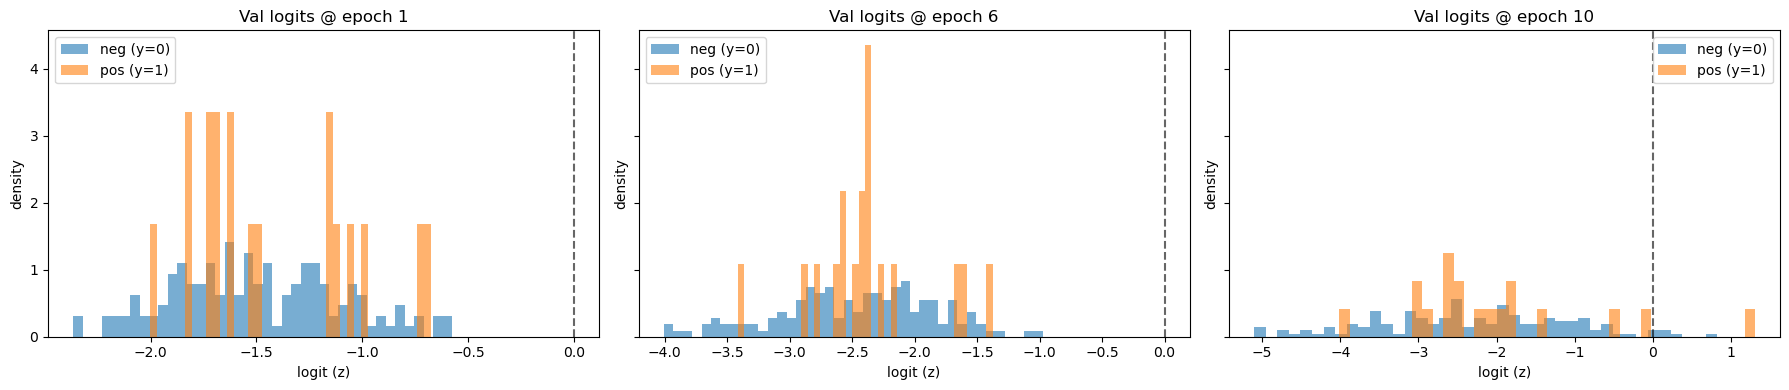

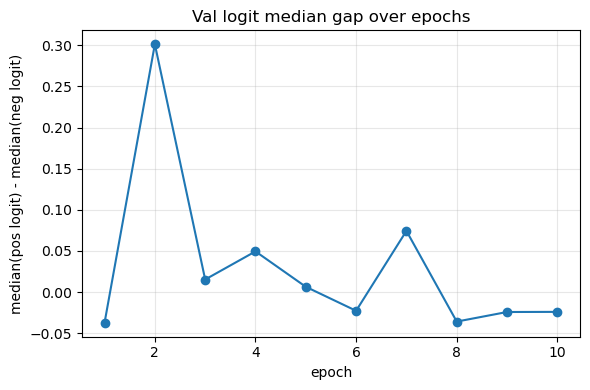

Train Loss,█▃▃▃▂▂▂▂▂▁
Val AUPR,▅▃▁▂▂▄▁▄▇█▇
Val AUROC,▁▆█▅█▆▄▃▅▅▅
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▁█▂▃▂▁▃▁▁▁
val_neg_median_logit,▆▇▅▁▆▁█▆▆▁
val_pos_median_logit,▆█▅▂▆▁█▅▆▁
Train Loss,0.25525
Val AUPR,0.18448
Val AUROC,0.53885
Val Loss,0.35783


In [25]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 10

all_binders = interaction_df["target_binder_ID"].tolist()

# all dataset: binder_enb, target_emb, label
ALL_btl = binder_target_label(targets_dataset, binders_dataset, all_binders, interaction_df)

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]

    train_targets = cv_splits[i][1]
    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]

    # loaders
    train_loader   = DataLoader(train_binders,   batch_size=20, shuffle=True, generator = torch.Generator().manual_seed(0))
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="CLIP_PPint_metaanalysis",
            name=f"split{i+1}_{runID}",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

`validation_dataset` / `training_dataset` store embedding of binder, embedding of target and label (binder - 1, non-binder - 0)